# Matcha Tutorial for CRT-TPC Matching

[matcha](https://github.com/andrewmogan/matcha/tree/main) (pronounced like "match" and not like the tea) is a repository that contains algorithms and data structures for CRT-TPC matching. It is designed to be input-agnostic, meaning that `lartpc_mlreco3d` can interface with it more easily than with LArSoft. An interface with matcha exists in `lartpc_mlreco3d` which fills the appropriate data structures and runs the matching algorithm. In principle, the steps to run CRT-TPC matching are simple:

1. Fill lists of matcha.Track and matcha.CRTHit instances
2. Run the matching algorithm
3. ???
4. Profit

In fact, step 1 is taken care of in the `run_crt_tpc_matching` post-processor of `lartpc_mlreco3d`. The `Track` class is constructed using information from `larcv.Particle` objects while the `CRTHit` class uses `larcv.CRTHit` information (which is itself constructed from the `sbnobj.CRTHit` class). 

# Setup

At the time of this writing, a certain lazy `matcha` author was on vacation and therefore didn't keep up with the latest `lartpc_mlreco3d`. Because of this, we need to run some awkward setup steps to point to a fork of `lartpc_mlreco3d` that runs with `matcha`. 

The cell below should correctly configure the necessary paths for most cases. The exception to this is if your `icarus_ml_workshop_2023` directory is not in your S(3)DF `$HOME` area. Check the output of this cell to make sure it correctly prints your username, which system you're one (SDF or S3DF), and your `WORKSHOP_DIR`.

In [1]:
import os, sys
import importlib
import numpy as np
import torch
import yaml

USER = os.environ.get('USER')
HOME = os.environ.get('HOME')
print('Hello, {}!'.format(USER))

IS_S3DF = False
if os.path.exists('/sdf/data/neutrino/{}'.format(USER)):
    print('You are on S3DF.')
    IS_S3DF = True
else:
    print('You are on SDF.')
    
WORKSHOP_DIR = '{}/icarus_ml_workshop_2023/'.format(HOME)
if not os.path.exists(WORKSHOP_DIR):
    print('Could not find WORKSHOP_DIR {}. Trying recursive find relative to {}'.format(WORKSHOP_DIR, HOME))
    import subprocess

    # Run the find command
    command = 'find $HOME -type d -name "icarus_ml_workshop_2023"'
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    # Store the output in a variable
    output = result.stdout.strip()
    
    if output == '':
        raise ValueError('''
            Workshop directory not found. Please configure the WORKSHOP_DIR variable in this 
            cell to point to your icarus_ml_workshop_2023 directory.''')

    print('Using workshop dir at {}'.format(output))
    
    WORKSHOP_DIR = output + '/'

else:
    print('Using WORKSHOP_DIR {}'.format(WORKSHOP_DIR))

Hello, amogan!
You are on S3DF.
Using WORKSHOP_DIR /sdf/home/a/amogan/icarus_ml_workshop_2023/


This next cell can be ignored if you're on S3DF.

In [2]:
# Install Andrew's fork of lartpc_mlreco3d if on SDF
SDF_SOFTWARE_DIR = ''
if not IS_S3DF:
    os.chdir('/sdf/group/neutrino/{}/'.format(USER))
    os.system('git clone https://github.com/andrewmogan/lartpc_mlreco3d.git lartpc_mlreco3d_andrew_fork')
    SDF_SOFTWARE_DIR = '/sdf/group/neutrino/{}/lartpc_mlreco3d_andrew_fork/'
else:
    print('Nothing to see here. Move along.')

Nothing to see here. Move along.


Next, we check if `matcha` can be imported. If not, this next cell will clone it to your `/sdf/group/neutrino/$USER` area and run the installation. Check that this cell prints `matcha import successful`. 

In [3]:
# Check if matcha is installed. If not, install it in /sdf/group/neutrino/$USER/.
package_name = 'matcha'

try:
    importlib.import_module(package_name)
    print('matcha import successful.')
except ImportError:
    print('matcha import failed. Attempting to install from Github...')
    os.chdir('/sdf/group/neutrino/{}/'.format(USER))
    os.system('git clone https://github.com/andrewmogan/matcha.git')
    os.chdir('matcha')
    os.system('python3 -m pip install .')
    try:
        # Try again
        importlib.import_module(package_name)
        print('matcha import successful.')
    except:
        raise ImportError('matcha still not found. Time to panic.')

matcha import successful.


Before proceeding, we need to make sure the relevant directories exist. Check the output of this next cell for any errors. 

In [4]:
# Check and set necessary paths
SOFTWARE_DIR = '/sdf/group/neutrino/amogan/lartpc_mlreco3d_myfork/'
if not IS_S3DF:
    SOFTWARE_DIR = SDF_SOFTWARE_DIR
MATCHA_DIR = '/sdf/group/neutrino/{}/matcha'.format(USER)
CONFIG_PATH = WORKSHOP_DIR+'post_processors/crt_tpc_matching/'
ANA_CONFIG = CONFIG_PATH + 'crt_tpc_ana_config.cfg'
MODEL_CONFIG = CONFIG_PATH + 'dhk_config.cfg'

# Check directories 
if not os.path.exists(SOFTWARE_DIR):
    raise ValueError('Software directory {:s} does not exist'.format(SOFTWARE_DIR))
if not os.path.exists(MATCHA_DIR):
    raise ValueError('matcha directory {:s} does not exist'.format(MATCHA_DIR))
if not os.path.exists(CONFIG_PATH):
    raise ValueError('Config directory {:s} does not exist'.format(CONFIG_PATH))
if not os.path.exists(ANA_CONFIG):
    raise FileNotFoundError('Ana config file {:s} does not exist'.format(ANA_CONFIG))
if not os.path.exists(MODEL_CONFIG):
    raise FileNotFoundError('Model config file {:s} does not exist'.format(MODEL_CONFIG))
    
sys.path.append(SOFTWARE_DIR)

Finally, we load the necessary configurations.

In [5]:
from mlreco.main_funcs import process_config

# Load anatools config file
#DATA_PATH = '/sdf/data/neutrino/icarus/bnb_numu_cosmic/sample/numu_corsika_mini_raw.h5'
DATA_PATH = '/sdf/group/neutrino/koh0207/logs/nu_selection/numu/sample/numu_corsika_mini_reco.h5'
if not IS_S3DF:
    DATA_PATH = '/sdf/group/neutrino/icarus/bnb_numu_cosmic/sample/numu_corsika_mini_raw.h'
analysis_config = yaml.safe_load(open(ANA_CONFIG, 'r').read().replace('DATA_PATH', DATA_PATH))

cfg = yaml.load(open(MODEL_CONFIG, 'r'), Loader=yaml.Loader)
process_config(cfg, verbose=False)


Config processed at: Linux sdfampere001 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES="0"



# Running the Post-Processor

To run the CRT-TPC matching post-processor, you'll need to add this block to your analysis config under `post_processing`:

```yaml
post_processing:
  run_crt_tpc_matching:
    volume_boundaries: [[-358.49, 358.49], [-181.86, 134.96], [-894.95, 894.95]]
    crthit_keys: ['crthits']
    matcha_config_path: 'matcha_config.yaml'
    minimum_pe: 50
```

The `volume_boundaries` are ICARUS-specific and would need to be changed for other detectors. `crthit_keys` looks for the appropriate keys in the `data` dictionary output by the ML chain. `matcha_config_path` should point to a valid `matcha` config file. yaml configuration for `matcha` will be explained later, but if in doubt, use the default config under `/path/to/matcha/config/default.yaml`. Finally, `minimum_pe` is just a simple PE threshold for CRT hits to be considered. This will likely be moved into the `matcha` yaml configuration soon, so this may be deprecated by the time you're reading this.

Assuming this block exists, just run the `AnaToolsManager` like usual:

In [6]:
from analysis.manager import AnaToolsManager
manager = AnaToolsManager(analysis_config)

manager.initialize()

Welcome to JupyROOT 6.22/08
Registered /sdf/group/neutrino/koh0207/logs/nu_selection/numu/sample/numu_corsika_mini_reco.h5


In [7]:
data, result = manager.forward(iteration=0)

Note that the CRT-TPC matching post processor will only run on files that have the `crthits` dataset parsed. You can check this using the cell below.

In [8]:
if 'crthits' not in data.keys():
    raise ValueError('crthits not found in data dictionary. Make sure DATA_PATH points to a valid file.')
else:
    print('Good to go')

Good to go


In [9]:
manager.load_representations(data, result) # This will save 'Particle' and 'Interaction' instances to result dict directly

This next function takes the `result['interactions']` dataset and checks if the interactions contain any CRT hits that have been matched to a track. 

In [10]:
def has_crthit_match(interactions):
    found_crt_match = False
    interactions_with_match = []
    for interaction_list in interactions:
        for interaction in interaction_list:
            if interaction.crthit_matched:
                found_crt_match = True
                interactions_with_match.append(interaction.id)
                break

    if found_crt_match:
        print('CRT match found in interactions:', interactions_with_match)
    else:
        print('No interactions found with CRT hit match')

Since we haven't run `matcha` yet, we don't expect there to be any matches. 

In [11]:
has_crthit_match(result['interactions'])

No interactions found with CRT hit match


Now, we run the CRT-TPC matching post-processor. You should see your yaml configuration printed below as well as the path where your output `.pkl` file is stored. We'll see how to use this output file shortly. 

In [12]:
manager.run_post_processing(data, result)

Running CRT matching...
*******Running with config********
 dca_parameters:
  isdata: false
  method: simple
  threshold: 50
  trigger_timestamp: None
file_save_config:
  save_file_name: matcha_output.pkl
  save_file_path: ./
  save_to_file: true
match_making_parameters:
  matching_method: dca
pca_parameters:
  direction_method: pca
  min_points_in_radius: 10
  radius: 10

**********************************
matcha output saved to .//matcha_output.pkl
Done CRT matching.


Let's see if we found any matches by using `has_crthit_match` again.

In [13]:
has_crthit_match(result['interactions'])

CRT match found in interactions: [1]


As you can see, this post-processor modifies the `interactions` dataset in place to specify which interactions contain a particle with a matched `CRTHit`. The ID of the corresponding track and CRT hit can be obtained using `interaction.crthit_matched_particle_id` and `interaction.crthit_id`, respectively.

> **Note:**
> In the future, `matcha` will modify the `Particle` class to contain matched CRT hit information instead of the `Interaction` class. 

And that's it! To see how to load and visualize the `matcha` output, have a look at the `visualizer.ipynb` notebook in the `matcha` top directory. Before that, let's talk about what's actually happening under the hood. 

# Matching Algorithm Overview

The matching algorithm contained in matcha is a Python port of [code already developed in LArSoft for the ICARUS experiment](https://github.com/SBNSoftware/icaruscode/blob/develop/icaruscode/CRT/CRTUtils/CRTT0MatchAlg.h). While the implentation here may differ slightly, the credit for algorithm development goes to the original authors of the LArSoft code. 

The purpose of the matching algorithm is to identify tracks in the LArTPC which are cosmogenic in origin, as opposed to neutrino-induced. Tracks identified as cosmic can then be rejected as background, thereby enhancing the signal "purity" of the neutrino sample. To this end, modern LArTPCs generally use cosmic ray tagger (CRT) planes surrounding the detector to identify particles that originated outside the active detector volume. This matching algorithm seeks to determine if tracks in the detector are likely cosmics by checking if the track timing and geometry are consistent with a CRT "hit."

For each track in a LArTPC image (or "event"), the track start and end points, as well as their direction unit vectors, are estimated using [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). Each point and unit vector then defines a line in 3D space. For each CRT hit, we then calculate the distance of closest approach (DCA) between the extrapolated track line and the CRT hit. If the DCA falls below some configurable threshold, the pair is considered a match candidate. The "best" match is then determined to be the pair with the minimum DCA. 

The image below (credit to Michelle Stancari) shows a cartoon of this process.

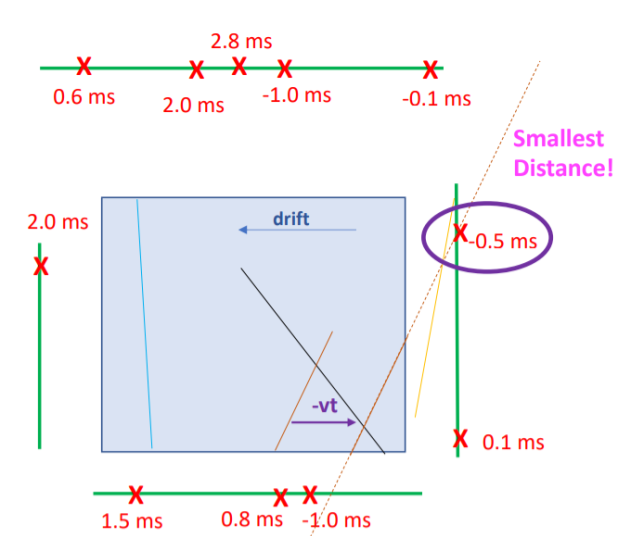

In [14]:
from IPython import display
display.Image("/sdf/home/a/amogan/crt_tpc_diagram.png")

# `matcha` Classes

Before moving on, let's take a look at the data structures `matcha` uses to perform the matching.  

## `Track` Class
The `Track` class attributes are based on the `Particle` class from [lartpc_mlreco3d](https://github.com/DeepLearnPhysics/lartpc_mlreco3d/blob/develop/analysis/classes/Particle.py). The _required_ attributes are
- `id`: unique instance identifier
- `image_id`: identifier of the track image (or "event").
- `interaction_id`: identifier of the track interaction (or "vertex").
- `points`: (N, 3) array of 3D track points in cm.
- `depositions`: (N, 3) array of track point energy depositions. This array is used for determining track track and end points based on which end of the track has greater average energy within a given radius. Since this is relative, the specific unit used doesn't matter.

There also _optional_ Track attributes and class methods related to finding the track start and end point positions and directions. Since `lartpc_mlreco3d` now has a post processor that handles these, you shouldn't have to worry about them, so they're not discussed here. See the `matcha` README for more information.

## `CRTHit` Class
The available attributes in the `matcha.CRTHit` class is based on the implementation in [larcv](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/CRTHit.h), which is in turn based on the implementation in [sbnobj](https://github.com/SBNSoftware/sbnobj/blob/develop/sbnobj/Common/CRT/CRTHit.hh). The _required_ attributes are
- `id`: unique instance identifier
- `t0_sec`: seconds part of the hit t0. For Monte Carlo (MC), this will be 0. 
- `t0_ns`: nanoseconds part of the hit t0, relative to `t0_sec`. 
- `t1_ns`: timestamp of the CRT hit relative to the trigger timestamp. Only needed for data, not MC.
- `position_x`: x-position in cm.
- `position_y`: y-position in cm.
- `position_z`: z-position in cm.

The _optional_ attributes are
- `error_x`: x-position error in cm. Only necessary for alternative DCA calculations. Default value is 0.
- `error_y`: y-position error in cm. Only necessary for alternative DCA calculations. Default value is 0.
- `error_z`: z-position error in cm. Only necessary for alternative DCA calculations. Default value is 0.
- `total_pe`: Total number of photoelectrons (PE). Default value is -1.
- `plane`: Integer identifying the CRT wall. Default value is -1.
- `tagger`: String idenifying the CRT wall. Default value is `''`.

All of these attributes should be available from the larcv or sbnobj CRTHit instances. 

`CRTHit` contains one method, `get_time_in_microseconds`, which uses the provided t0 information and converts it to a value in microseconds. This is called automatically when running `get_track_crthit_matches`. 

## `MatchCandidate` Class

When a match between a `Track` and `CRTHit` is found, the matched instances are stored in a `MatchCandidate` class instance. The attributes of this class are
- `track_id`: the `id` of the matched `Track` instance.
- `crthit_id`: the `id` of the matched `CRTHit` instance.
- `distance_of_closest_approach`: calculated DCA between the matched `Track` and `CRTHit`. 

## yaml Configuration

In addition to lists of `Track` and `CRTHit` instances, the match-making algorithm takes as input a yaml congiruation file containing tuneable parameters. The default configuration can be found in `/path/to/matcha/config/default.yaml`:

```yaml
match_making_parameters:
  matching_method: 'dca'

dca_parameters:
  threshold: 50
  method: 'simple'
  trigger_timestamp: None
  isdata: False
  
pca_parameters:
  radius: 10
  min_points_in_radius: 10
  direction_method: 'pca'

file_save_config:
  save_to_file: True
  save_file_path: './'
  save_file_name: 'matcha_output.pkl'
```

The default matching method is `dca` (distance of closest approach). `dca_parameters` contains fields that specify 

- a distance `threshold` in centimeters,
- a `simple` method (currently the only method),
- a `trigger_timestamp` (only necessary when running on data), and
- an `isdata` boolean flag. Note that this must be `True` if `trigger_timestamp` is not `None`. 

Note that the `pca_parameters` specifies fields for PCA estimation of `Track` start and end point position and direction estimation if and only if that information is not present in the `Track` instances. Since `lartpc_mlreco3d` has a separate post processor for this, we don't need it here. Finally, the `file_save_config` block specifies where to store the match-making output. 

## ~~My to-do list~~ Exercises for the Reader!
- Fix all the Github issues for me
- Write efficiency metrics for me
- Combine with PMT information
    - For each matched track, check the interaction flash time. If the flash time is less than the CRT time, the track is exiting and therefore neutrino-induced.
- Implement alternative matching methods
    - Currently, a simple DCA calculation is the only matching method. You can write a separate matching function in `dca_methods.py` (poorly named for historical reasons; may be renamed at a later date) and configure the `matching_method` yaml parameter to point to your new function.
- Implement unit tests into matcha
- Run the matching algorithm using your data file of choice
    - Load the output file into visualizer.ipynb. Do the plotted matches look visually reasonable?
    - How many matches do you get when using a 50 cm threshold? 100 cm? 200 cm?